<b>Set the fields paramiters</b>

In [3]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
from PIL import Image
import fields_synthesis as fs

In [4]:
class AZPmask:
    def __init__(self,lam=.7,focus=200.,du=270,dv=480,dx=5.):
        self.lam = lam*10**-3
        self.foc = focus
        self.du = du
        self.dv = dv
        self.dx = dx*10**-3
        self.Ab = np.zeros((du*2,dv*2),dtype=float)
    
    def set_abb(self,Ab):
        self.Ab = Ab
        
    def mask_gen(self):
        yt = np.arange(-self.du, self.du)*self.dx    
        xt = np.arange(-self.dv, self.dv)*self.dx
        x, y = np.meshgrid(xt, yt)
        
        self.x = x
        self.y = y
        
        k  = 2*pi/self.lam
        r2 = x**2+y**2
        Lens = k*r2/(2*self.foc)
        self.Lens = Lens
        
        Fi = Lens + self.Ab        
        M = np.int32(Fi.max()/pi)
        
        lensf  = np.zeros((2*self.du,2*self.dv),dtype = bool)
        self.Fi = Fi
        
        #for ii in range(0,M,2):        
        #    lensf = lensf | ( ( Fi  > pi*ii ) & (Fi <= (ii+1)*pi ) ) 
        lensf = np.int8( np.angle(np.exp(1j*Fi)) > 0 )
        
        self.lensf = np.uint8(lensf)
    def plt_lsf(self):
        plt.imshow(self.lensf)
        plt.colorbar()

<h2> Calculate the diffractive angle and DLP tilt </h2>

In [5]:
lam = 0.544
g = 17*pi/180
d = 5.4
n = -5

a = np.arccos( -n*lam/(2*d*np.sin(g)) ) - g 
print('alfa = {:.2f}'.format(a*180/pi))

b = np.arcsin(np.sin(a) - lam*n/d)
print('beta = {:.2f}'.format(b*180/pi))

ref = a + 2*g
print('ref = {:.2f}'.format(ref*180/pi))



alfa = 13.52
beta = 47.52
ref = 47.52


<h2> Prepare aberrated lens </h2>

In [7]:
from zernike import RZern

um = 270.
vm = 480.
du = 1/um #Becouse u*du must be 1 - for ones circle for Zernike terms

ut = np.arange(-1, 1,du)
vt = np.arange(-vm/um, vm/um,du)
v, u = np.meshgrid(vt, ut)

cart = RZern(5)
cart.make_cart_grid(v, u)
c = np.zeros(cart.nk)

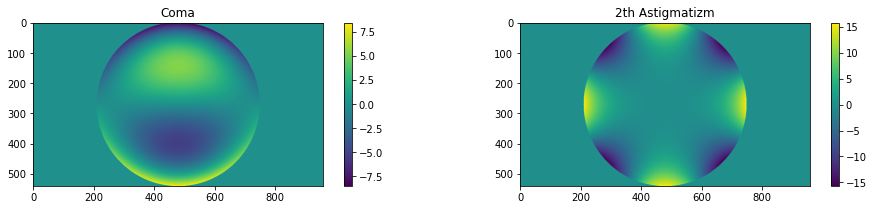

In [8]:
c *= 0
c[5] = -3.15

Fi = cart.eval_grid(c, matrix=True)
circ = np.int8( ~np.isnan(Fi) )
Fi[np.isnan(Fi)] = 0
Ast_comp = Fi

c *= 0
c[6] = 3

Fi_coma = cart.eval_grid(c, matrix=True)
Fi_coma[np.isnan(Fi_coma)] = 0

c *= 0
c[13] = 5

Fi_ast3 = cart.eval_grid(c, matrix=True)
Fi_ast3[np.isnan(Fi_ast3)] = 0

plt.figure(figsize=(16,3))

ax = plt.subplot2grid((1,2),(0,0), title = "Coma")
plt.imshow(Fi_coma)
plt.colorbar()

ax = plt.subplot2grid((1,2),(0,1), title = "2th Astigmatizm")
plt.imshow(Fi_ast3)
plt.colorbar()

<h3> Ordinar focusing </h3>

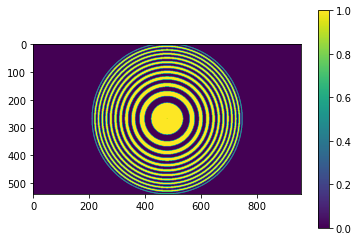

In [9]:
AZP = AZPmask(focus=150.,lam=0.544)
AZP.mask_gen()

DL_foc150  = np.angle( np.exp( 1j*(AZP.Lens) ) ) > 0
DL_foc150 = np.uint8(DL_foc150*circ)
plt.imshow( DL_foc150 )
plt.colorbar()

from PIL import Image

img = Image.fromarray(DL_foc150*255)
img.save('150.bmp',mode="RGB")

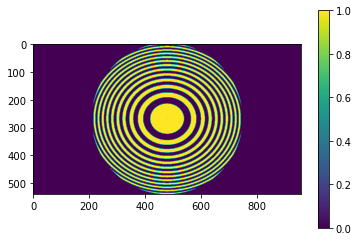

In [10]:
AZP = AZPmask(focus=150.,lam=0.544)
AZP.mask_gen()

DL_foc150_ast0  = np.angle( np.exp( 1j*(AZP.Lens + Ast_comp) ) ) > 0
DL_foc150_ast0 = np.uint8(DL_foc150_ast0*circ)
plt.imshow( DL_foc150_ast0 )
plt.colorbar()

In [11]:
#Save file for dot focusing with first astigmatizm compensatio and shifting
DL_dot  = np.angle( np.exp( 1j*(AZP.Lens + Ast_comp*0 - 200*vt) ) ) > 0
DL_dot = np.uint8(DL_dot)*circ
#plt.imshow(DL_dot)
#plt.colorbar()
img = Image.fromarray(DL_dot*255)
img = img.convert('L')
img.save('dot_abless.bmp',mode='L')

<h3> Coma </h3>

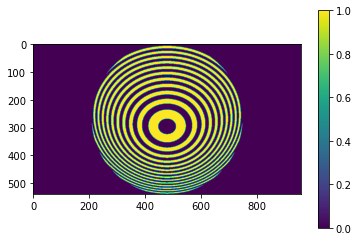

In [12]:
DL_coma = np.angle( np.exp( 1j*(AZP.Lens + Fi_coma + Ast_comp ) ) ) > 0
DL_coma = np.uint8(DL_coma)*circ
plt.imshow(DL_coma)
plt.colorbar()

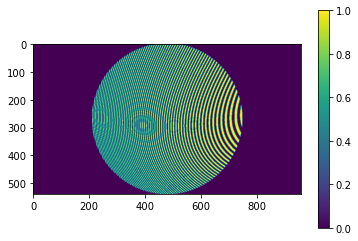

In [13]:
#Save file for dot focusing-COMA with first astigmatizm compensatio and shifting
DL  = np.angle( np.exp( 1j*(AZP.Lens + Ast_comp + Fi_coma - 200*vt) ) ) > 0
DL = np.uint8(DL)*circ
plt.imshow(DL)
plt.colorbar()
img = Image.fromarray(DL*255)
img = img.convert('L')
img.save('dot_coma.bmp',mode='L')

<h3> Vertical secondary astigmatism $Z_4^{2}$  </h3>

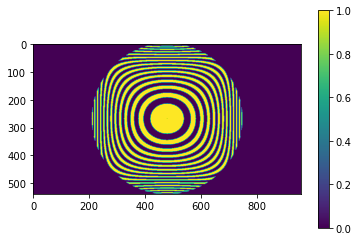

In [14]:
DL_ast3  = np.angle( np.exp( 1j*(AZP.Lens + Ast_comp + Fi_ast3) ) ) > 0
DL_ast3 = np.uint8(DL_ast3)*circ
plt.imshow(DL_ast3)
plt.colorbar()

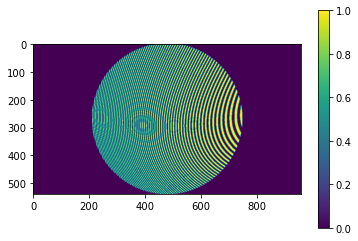

In [15]:
DL_coma_shift  = np.angle( np.exp( 1j*(AZP.Lens + Ast_comp + Fi_ast3 - 200*vt) ) ) > 0
DL = np.uint8(DL)*circ
plt.imshow(DL)
plt.colorbar()
img = Image.fromarray(DL*255)
img = img.convert('L')
img.save('dot_ast3.bmp',mode='L')

<b>IAP RAS emblem. Too difficalt for imaging</b>

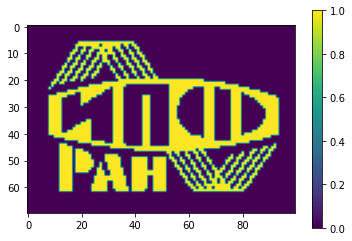

In [17]:
file = './IAPRAS.bmp'

with Image.open(file) as im:
    source = im.split()[0]

imn = np.array(source)[9:-2,11:-3]
imb = imn > 120
plt.imshow(imb*1)
plt.colorbar()

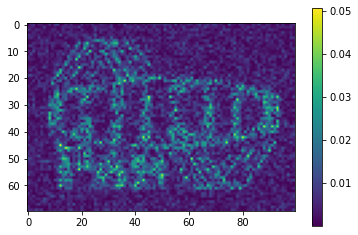

In [18]:
Im = np.zeros((540,960),dtype=complex)
Im[270-35:270+35,480-50:480+50] = imn*np.random.rand(70,100)
fa =  np.angle( np.fft.fft2(Im) )  
fab = fa
plt.imshow( np.abs( np.fft.ifft2(np.exp(1j*fa)) )[270-35:270+35,480-50:480+50] )
plt.colorbar()


<h3>Load the smile and prepare the diffractive image</h3>

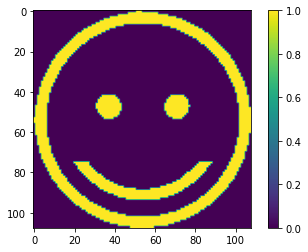

In [33]:
file = './smile2.jpg'

with Image.open(file) as im2:
    source = im2.split()[0]

im2 = -1*np.array(source) > -15
plt.imshow( im2*1 )
plt.colorbar()

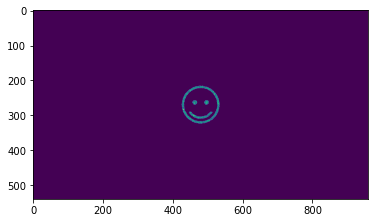

In [34]:
Im2 = np.zeros((540,960),dtype=complex)
DX = 70*2*0
DY = 40*0
Im2[270+DY-54:270+DY+54,480+DX-54:480+DX+54] = im2*np.random.rand(108,108)
plt.imshow( np.abs(Im2) )

<b> Prepare amplitude zone plate</b>

Shifting is necessary to shift from constant term

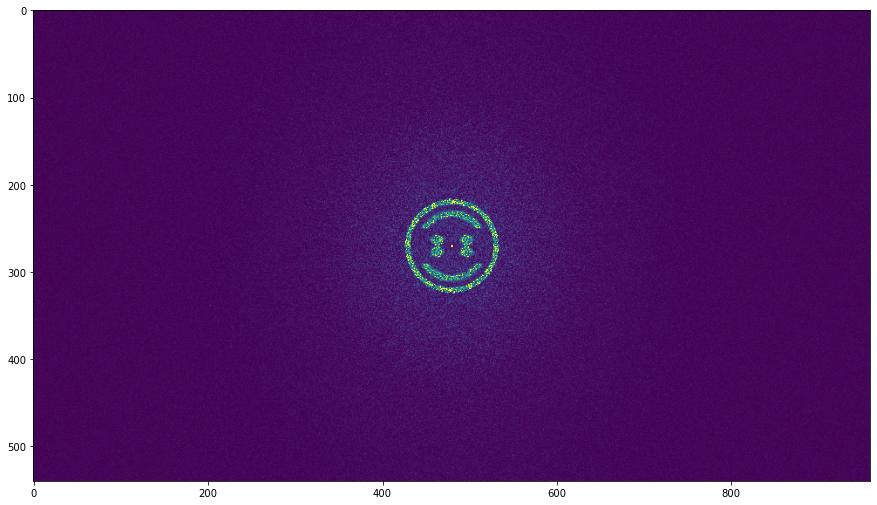

In [35]:
fa =  ( np.angle( np.fft.fft2(np.fft.fftshift(Im2)) )  )
fab = ( fa > 0 )

plt.figure(figsize=(15,20))
plt.imshow( np.fft.ifftshift( np.abs( np.fft.ifft2(fab) )), vmax = 0.01)

In [18]:
img = Image.fromarray(fab*255)
img = img.convert('L')
img.save('smile_nl.bmp',mode='L')

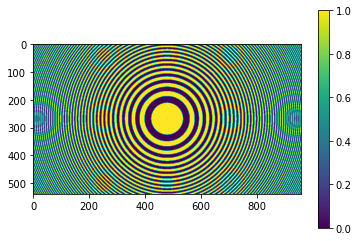

In [19]:
AZP = AZPmask(focus=150.,lam=0.544)
AZP.mask_gen()
plt.imshow( AZP.lensf )
plt.colorbar()

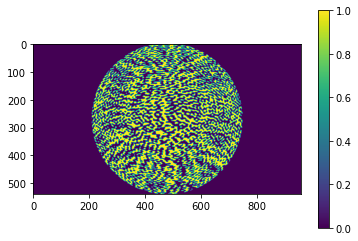

In [36]:
fa =  np.angle( np.fft.fft2(np.fft.fftshift(Im2) ) )  
fab2 = np.angle( np.exp( 1j*(fa + AZP.Lens + Ast_comp*1.1-40*vt)*circ ) ) > 0
Smile = np.uint8( np.angle( np.exp( 1j*(fa + AZP.Lens + Ast_comp )*circ ) ) > 0 )
plt.imshow(Smile)
plt.colorbar()
img = Image.fromarray(fab2*255)
img = img.convert('L')
#img.save('smile_foc.bmp',mode='L')

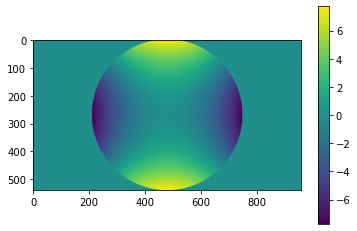

In [37]:
plt.imshow(Ast_comp)
plt.colorbar()

With this bloc we can save images with different colors

In [38]:
from skimage import data, io
RGB = np.array((*"RGB",))
red = np.multiply.outer(DL*255, RGB=='R')
#io.imsave('red.bmp', red)

<h2> Images creating </h2>

<h3> Image with PSFs </h3>

<b> Obtains first row with PSFs </b>

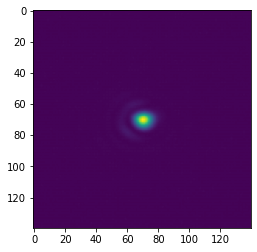

In [39]:
file = './dlp/dot_abless_0.2_f150.bmp'
dim = 70
with Image.open(file) as im2:
    PSF_noab = np.float64( np.array(im2.split()[0]) )
yc,xc = np.unravel_index( PSF_noab.argmax(), PSF_noab.shape )
PSF_noab = PSF_noab/PSF_noab.max()*255
plt.imshow(PSF_noab[yc-dim:yc+dim,xc-dim:xc+dim])


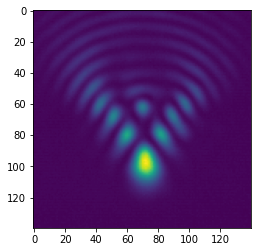

In [40]:
file = './dlp/dot_coma_2.0_f150.bmp'

with Image.open(file) as im2:
    PSF_coma = np.float64( np.array(im2.split()[0]) )
PSF_coma = PSF_coma/PSF_coma.max()*255
plt.imshow(PSF_coma[yc-dim:yc+dim,xc-dim:xc+dim])

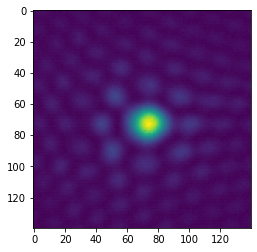

In [41]:
file = './dlp/dot_vertical_secondary_astigmatizm_2.0_f150.bmp'

with Image.open(file) as im2:
    PSF_ast3 = np.array(im2.split()[0])
PSF_ast3 = PSF_ast3/PSF_ast3.max()*255
plt.imshow(PSF_ast3[yc-dim:yc+dim,xc-dim:xc+dim])

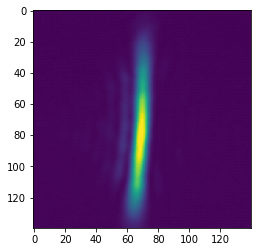

In [42]:
file = './dlp/dot_abless_2.0_f150_2_without_astComp.bmp'

with Image.open(file) as im2:
    PSF_ast0 = np.array(im2.split()[0])
PSF_ast0 = PSF_ast0/PSF_ast0.max()*255
yc_ast0,xc_ast0 = np.unravel_index( PSF_ast0.argmax(), PSF_ast0.shape )

plt.imshow(PSF_ast0[yc_ast0-dim:yc_ast0+dim,xc_ast0-dim:xc_ast0+dim])

<b> Obtain second row with intensity profiles </b>

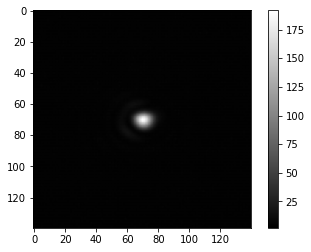

In [45]:
file = './dlp/dot_abless_0.2_f150.bmp'
dim = 70
with Image.open(file) as im2:
    PSF_noabN = np.float64( np.array(im2.split()[0]) )
yc,xc = np.unravel_index( PSF_noabN.argmax(), PSF_noab.shape )
plt.imshow(PSF_noabN[yc-dim:yc+dim,xc-dim:xc+dim],'gray')
plt.colorbar()
xc_dot = np.unravel_index( PSF_noabN.argmax(), PSF_noabN.shape )[1]

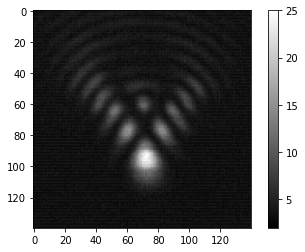

In [55]:
file = './dlp/dot_coma_0.2_f150.bmp'

with Image.open(file) as im2:
    PSF_comaN = np.float64( np.array(im2.split()[0]) )
plt.imshow(PSF_comaN[yc-dim:yc+dim,xc-dim:xc+dim],'gray')
plt.colorbar()
xc_coma = np.unravel_index( PSF_comaN.argmax(), PSF_comaN.shape )[1]

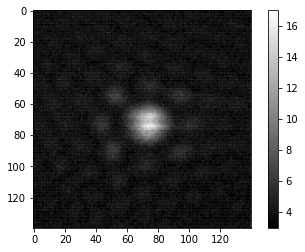

In [47]:
file = './dlp/dot_vertical_secondary_astigmatizm_0.2_f150.bmp'

with Image.open(file) as im2:
    PSF_ast3N = np.array(im2.split()[0])
plt.imshow(PSF_ast3N[yc-dim:yc+dim,xc-dim:xc+dim],'gray')
plt.colorbar()
xc_ast3 = np.unravel_index( PSF_ast3N.argmax(), PSF_ast3N.shape )[1]+1 #Insert +1 becouse noise leads to fluctuation into maximum

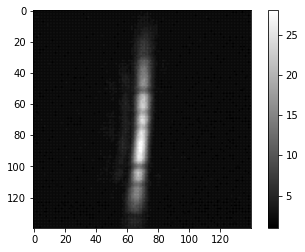

In [48]:
file = './dlp/dot_abless_0.2_f150_2_without_astComp.bmp'

with Image.open(file) as im2:
    PSF_ast0N = np.array(im2.split()[0])
plt.imshow(PSF_ast0N[yc_ast0-dim:yc_ast0+dim,xc_ast0-dim:xc_ast0+dim],'gray')
plt.colorbar()
#xc_ast3 = np.unravel_index( PSF_ast0N.argmax(), PSF_ast0N.shape )[1]

<b> Image bilding </b>

First row:

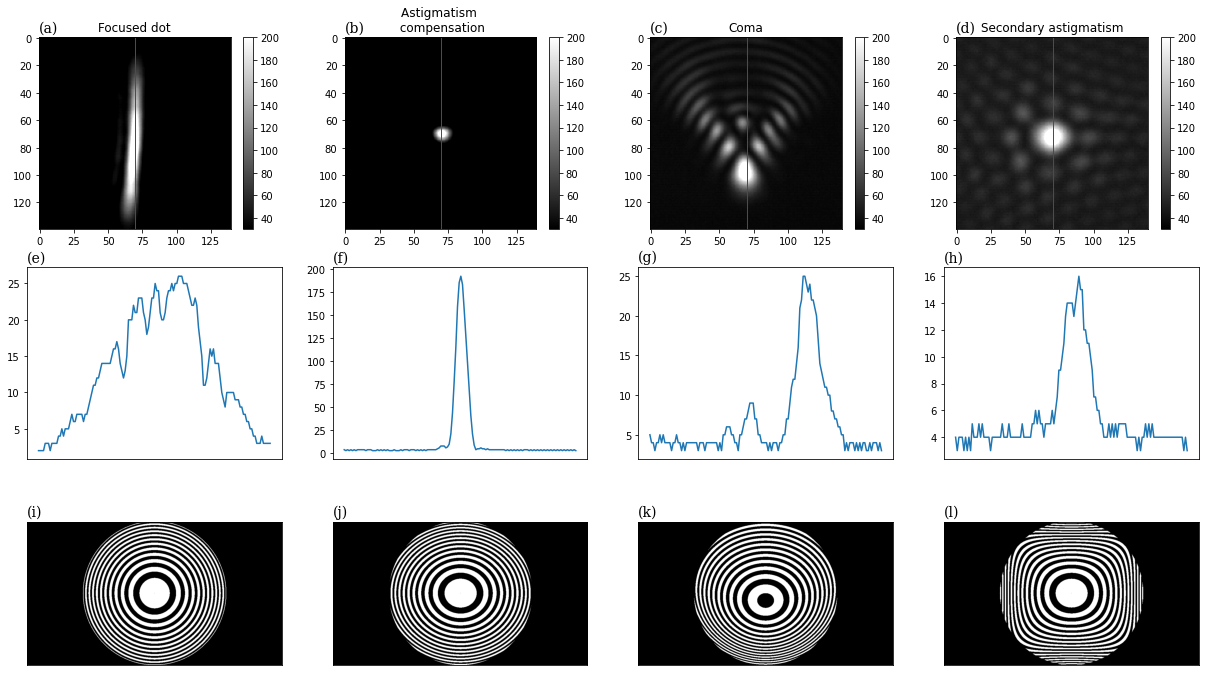

In [49]:
line = np.arange(0,dim*2)
coordx = np.zeros(2*dim,dtype=int)+70

plt.figure(figsize=(21,12))

ax = plt.subplot2grid((3,4),(0,0), title = "Focused dot")
plt.imshow( PSF_ast0[yc_ast0-dim:yc_ast0+dim,xc_ast0-dim:xc_ast0+dim], 'gray', vmin=30, vmax=200); 
plt.plot(coordx,line,color='red',linewidth=1)
plt.colorbar()
ax.set_title('(a)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(0,1), title = "Astigmatism \n compensation")
plt.imshow( PSF_noab[yc-dim:yc+dim,xc-dim:xc+dim], 'gray', vmin=30, vmax=200); 
plt.plot(coordx,line,color='red',linewidth=1)
#plt.yticks([])
#plt.xticks([])
plt.colorbar()
ax.set_title('(b)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(0,2), title = "Coma")
plt.imshow( PSF_coma[yc-dim:yc+dim,xc_coma-dim:xc_coma+dim], 'gray', vmin=30, vmax=200);
plt.plot(coordx,line,color='red',linewidth=1)
#plt.yticks([])
#plt.xticks([])
plt.colorbar()
ax.set_title('(c)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(0,3), title = "Secondary astigmatism")
plt.imshow( PSF_ast3[yc-dim:yc+dim,xc_ast3-dim:xc_ast3+dim], 'gray', vmin=30, vmax=200 );
plt.plot(coordx,line,color='red',linewidth=1)
#plt.yticks([])
#plt.xticks([])
plt.colorbar()
ax.set_title('(d)',loc='left', fontfamily='serif', fontsize=14)

#===SECOND ROW===
ax = plt.subplot2grid((3,4),(1,0))
plt.plot( PSF_ast0N[yc_ast0-dim:yc_ast0+dim,xc_ast0]); 
plt.xticks([])
ax.set_title('(e)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(1,1))
plt.plot( PSF_noabN[yc-dim:yc+dim,xc_dot]); 
plt.xticks([])
ax.set_title('(f)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(1,2))
plt.plot( PSF_comaN[yc-dim:yc+dim,xc_coma]); 
plt.xticks([])
ax.set_title('(g)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(1,3))
plt.plot( PSF_ast3N[yc-dim:yc+dim,xc_ast3]);  
plt.xticks([])
ax.set_title('(h)',loc='left', fontfamily='serif', fontsize=14)

#===THIRD ROW===
ax = plt.subplot2grid((3,4),(2,0))
plt.imshow( DL_foc150, 'gray'); 
plt.yticks([])
plt.xticks([])
ax.set_title('(i)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(2,1))
plt.imshow( DL_foc150_ast0, 'gray'); 
plt.yticks([])
plt.xticks([])
ax.set_title('(j)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(2,2))
plt.imshow( DL_coma, 'gray'); 
plt.yticks([])
plt.xticks([])
ax.set_title('(k)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((3,4),(2,3))
plt.imshow( DL_ast3, 'gray'); 
plt.yticks([])
plt.xticks([])
ax.set_title('(l)',loc='left', fontfamily='serif', fontsize=14)

save_img1 = False
if save_img1:
    filepath = './'
    filename = 'AZP_focusing2.jpg'        
    plt.savefig(filepath+filename, dpi=400, bbox_inches='tight')  

<h3>Image with smile </h3>

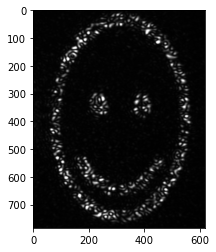

In [53]:
file = './dlp/smile.bmp'

with Image.open(file) as im2:
    Smile_im = np.float64( np.array(im2.split()[0]) )

plt.imshow(Smile_im[90:-150,660:-1],'gray')

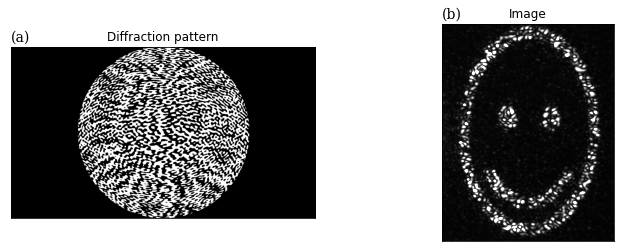

In [54]:
plt.figure(figsize=(12,4))

ax = plt.subplot2grid((1,2),(0,0), title = "Diffraction pattern")
plt.imshow( Smile, 'gray'); 
plt.yticks([])
plt.xticks([])
ax.set_title('(a)',loc='left', fontfamily='serif', fontsize=14)

ax = plt.subplot2grid((1,2),(0,1), title = "Image")
plt.imshow( Smile_im[90:-150,660:-1], 'gray',vmax=125); 
plt.yticks([])
plt.xticks([])
ax.set_title('(b)',loc='left', fontfamily='serif', fontsize=14)

save_img2 = False
if save_img2:
    filepath = './'
    filename = 'AZP_holo.jpg'        
    plt.savefig(filepath+filename, dpi=400, bbox_inches='tight')  